In [1]:
# 📌 Importing required libraries
import pandas as pd
import numpy as np
import re

# 📥 Load the Excel file - Sheet: 'Employee Data'
file_path = '/content/Employee data (2).xlsx'
df = pd.read_excel(file_path, sheet_name='Employee Data', header=1)

# 🧹 Drop unnecessary index column
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# ✅ 1. Fixing Misspelled Role
role_column = [col for col in df.columns if 'Role' in col.strip()]
if role_column:
    df[role_column[0]] = df[role_column[0]].replace({'senir associate': 'senior associate'})
else:
    print('⚠️ No "Role" column found.')

# ✅ 2. Handle Missing or Inconsistent "Years of Experience"
experience_column = 'Years of Experience'
if experience_column in df.columns:
    df[experience_column] = df[experience_column].astype(str).str.strip()
    df[experience_column] = df[experience_column].replace({'-': '0', '1-2': '1', '3 to 5': '3'})
    df[experience_column] = df[experience_column].apply(
        lambda x: re.split('-|to', x)[0].strip() if re.match(r'\d+[-to]\d+', x) else x
    )
    df[experience_column] = pd.to_numeric(df[experience_column], errors='coerce').fillna(0).astype(int)
else:
    print(f'⚠️ No "{experience_column}" column found.')

# ✅ 3. Replace NULL in 'Last Working Day' with 'No'
last_working_day_column = 'Last Working Day'
if last_working_day_column in df.columns:
    df[last_working_day_column] = df[last_working_day_column].fillna('No')
else:
    print(f'⚠️ No "{last_working_day_column}" column found.')

# ✅ 4. Handle remaining missing values (only in object columns)
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna('-')

# 👀 Preview final cleaned data
print('\n✅ Final Cleaned Data Preview:')
display(df.head())

# 💾 Save cleaned data to new file
output_file_path = '/content/Employee data (2).xlsx'
df.to_excel(output_file_path, index=False)
print(f'\n✅ Cleaned data saved to: {output_file_path}')



✅ Final Cleaned Data Preview:


,Name,Role,Location,Years of Experience,Active?,Current Comp (INR),Last Working Day
0,Aditi Khanna,Analyst,Jaipur,1,Y,653874.0,No
1,Pooja Kaur,Senior Analyst,Banglore,2,Y,798703.0,No
2,Kajal Mehta,Analyst,Banglore,1,Y,663851.0,No
3,Amaya Joshi,Analyst,Jaipur,0,Y,570000.0,No
4,Bilal Kulkarni,Associate,Jaipur,3,Y,976125.0,No



✅ Cleaned data saved to: /content/Employee data (2).xlsx


In [2]:
import pandas as pd
import sqlite3

# Load cleaned data
file_path = '/content/Employee data (2).xlsx'
df = pd.read_excel(file_path)

# Show data preview
df.head()


,Name,Role,Location,Years of Experience,Active?,Current Comp (INR),Last Working Day
0,Aditi Khanna,Analyst,Jaipur,1,Y,653874.0,No
1,Pooja Kaur,Senior Analyst,Banglore,2,Y,798703.0,No
2,Kajal Mehta,Analyst,Banglore,1,Y,663851.0,No
3,Amaya Joshi,Analyst,Jaipur,0,Y,570000.0,No
4,Bilal Kulkarni,Associate,Jaipur,3,Y,976125.0,No


In [3]:
# Connect to SQLite DB
import sqlite3
conn = sqlite3.connect("employee_compensation.db")
cursor = conn.cursor()

# Drop tables if rerunning
cursor.executescript('''
DROP TABLE IF EXISTS Employees;
DROP TABLE IF EXISTS Roles;
DROP TABLE IF EXISTS Locations;
DROP TABLE IF EXISTS Status;
''')

# Create Roles table
cursor.execute('''
CREATE TABLE Roles (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    role TEXT UNIQUE
);
''')

# Create Locations table
cursor.execute('''
CREATE TABLE Locations (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    location TEXT UNIQUE
);
''')

# Create Status table (Active? Y/N)
cursor.execute('''
CREATE TABLE Status (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    status TEXT UNIQUE
);
''')

# Create main Employees table with foreign keys
cursor.execute('''
CREATE TABLE Employees (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT,
    role_id INTEGER,
    location_id INTEGER,
    years_of_experience INTEGER,
    active_id INTEGER,
    current_comp_inr REAL,
    last_working_day TEXT,
    FOREIGN KEY (role_id) REFERENCES Roles(id),
    FOREIGN KEY (location_id) REFERENCES Locations(id),
    FOREIGN KEY (active_id) REFERENCES Status(id)
);
''')

conn.commit()
print("✅ Normalized tables created successfully.")


✅ Normalized tables created successfully.


In [4]:
import pandas as pd

# Load the cleaned Excel file
file_path = '/content/Employee data (2).xlsx'
df = pd.read_excel(file_path)

# Preview the cleaned data
df.head()


,Name,Role,Location,Years of Experience,Active?,Current Comp (INR),Last Working Day
0,Aditi Khanna,Analyst,Jaipur,1,Y,653874.0,No
1,Pooja Kaur,Senior Analyst,Banglore,2,Y,798703.0,No
2,Kajal Mehta,Analyst,Banglore,1,Y,663851.0,No
3,Amaya Joshi,Analyst,Jaipur,0,Y,570000.0,No
4,Bilal Kulkarni,Associate,Jaipur,3,Y,976125.0,No


In [5]:
# Connect to SQLite again
import sqlite3
conn = sqlite3.connect("employee_compensation.db")
cursor = conn.cursor()

# Insert unique Roles
roles = df['Role'].dropna().unique()
for role in roles:
    cursor.execute("INSERT OR IGNORE INTO Roles (role) VALUES (?)", (role.strip(),))

# Insert unique Locations
locations = df['Location'].dropna().unique()
for loc in locations:
    cursor.execute("INSERT OR IGNORE INTO Locations (location) VALUES (?)", (loc.strip(),))

# Insert unique Status values (from 'Active?' column)
statuses = df['Active?'].dropna().unique()
for status in statuses:
    cursor.execute("INSERT OR IGNORE INTO Status (status) VALUES (?)", (status.strip(),))

conn.commit()
print("✅ Lookup tables populated.")


✅ Lookup tables populated.


In [6]:
# Helper function to fetch ID from a table
def get_lookup_id(value, table, column):
    cursor.execute(f"SELECT id FROM {table} WHERE {column} = ?", (value.strip(),))
    result = cursor.fetchone()
    return result[0] if result else None

# Map Role, Location, and Status to their respective IDs
df['role_id'] = df['Role'].apply(lambda x: get_lookup_id(x, 'Roles', 'role'))
df['location_id'] = df['Location'].apply(lambda x: get_lookup_id(x, 'Locations', 'location'))
df['active_id'] = df['Active?'].apply(lambda x: get_lookup_id(x, 'Status', 'status'))

# Final preview before inserting
df[['Name', 'role_id', 'location_id', 'Years of Experience', 'active_id', 'Current Comp (INR)', 'Last Working Day']].head()


,Name,role_id,location_id,Years of Experience,active_id,Current Comp (INR),Last Working Day
0,Aditi Khanna,1,1,1,1,653874.0,No
1,Pooja Kaur,2,2,2,1,798703.0,No
2,Kajal Mehta,1,2,1,1,663851.0,No
3,Amaya Joshi,1,1,0,1,570000.0,No
4,Bilal Kulkarni,3,1,3,1,976125.0,No


In [7]:
# Insert data into normalized Employees table
for _, row in df.iterrows():
    cursor.execute('''
        INSERT INTO Employees (
            name, role_id, location_id, years_of_experience,
            active_id, current_comp_inr, last_working_day
        ) VALUES (?, ?, ?, ?, ?, ?, ?)
    ''', (
        row['Name'],
        row['role_id'],
        row['location_id'],
        int(row['Years of Experience']),
        row['active_id'],
        float(row['Current Comp (INR)']),
        row['Last Working Day']
    ))

conn.commit()
print("✅ Employee data inserted into normalized Employees table.")


✅ Employee data inserted into normalized Employees table.


In [8]:
# Join with lookup tables to verify correctness
query = '''
SELECT
    e.id,
    e.name,
    r.role,
    l.location,
    e.years_of_experience,
    s.status,
    e.current_comp_inr,
    e.last_working_day
FROM Employees e
JOIN Roles r ON e.role_id = r.id
JOIN Locations l ON e.location_id = l.id
JOIN Status s ON e.active_id = s.id
LIMIT 5;
'''
result = cursor.execute(query).fetchall()

# Display results
for row in result:
    print(row)


(1, 'Aditi Khanna', 'Analyst', 'Jaipur', 1, 'Y', 653874.0, 'No')
(2, 'Pooja Kaur', 'Senior Analyst', 'Banglore', 2, 'Y', 798703.0, 'No')
(3, 'Kajal Mehta', 'Analyst', 'Banglore', 1, 'Y', 663851.0, 'No')
(4, 'Amaya Joshi', 'Analyst', 'Jaipur', 0, 'Y', 570000.0, 'No')
(5, 'Bilal Kulkarni', 'Associate', 'Jaipur', 3, 'Y', 976125.0, 'No')


In [9]:
# Join all tables to verify data correctness
query = '''
SELECT
    e.id,
    e.name,
    r.role,
    l.location,
    e.years_of_experience,
    s.status,
    e.current_comp_inr,
    e.last_working_day
FROM Employees e
JOIN Roles r ON e.role_id = r.id
JOIN Locations l ON e.location_id = l.id
JOIN Status s ON e.active_id = s.id
ORDER BY e.id
LIMIT 10;
'''
result = cursor.execute(query).fetchall()

# Display the top 10 employee records
import pandas as pd
columns = ['ID', 'Name', 'Role', 'Location', 'Experience', 'Active?', 'Compensation (INR)', 'Last Working Day']
verified_df = pd.DataFrame(result, columns=columns)
verified_df


,ID,Name,Role,Location,Experience,Active?,Compensation (INR),Last Working Day
0,1,Aditi Khanna,Analyst,Jaipur,1,Y,653874.0,No
1,2,Pooja Kaur,Senior Analyst,Banglore,2,Y,798703.0,No
2,3,Kajal Mehta,Analyst,Banglore,1,Y,663851.0,No
3,4,Amaya Joshi,Analyst,Jaipur,0,Y,570000.0,No
4,5,Bilal Kulkarni,Associate,Jaipur,3,Y,976125.0,No
5,6,Girish Reddy,Analyst,Pune,1,Y,670531.0,No
6,7,Esha Dhillon,Analyst,Pune,1,Y,652076.0,No
7,8,Kashi Nair,Analyst,Banglore,1,Y,655787.0,No
8,9,Himanshu Dhillon,Senior Analyst,Pune,2,Y,895396.0,No
9,10,Hetal Bhatia,Senior Analyst,Pune,2,Y,820895.0,No


In [10]:
cursor.execute('''
CREATE VIEW IF NOT EXISTS ActiveEmployeesView AS
SELECT
    e.id,
    e.name,
    r.role,
    l.location,
    e.years_of_experience,
    e.current_comp_inr AS compensation,
    e.last_working_day
FROM Employees e
JOIN Roles r ON e.role_id = r.id
JOIN Locations l ON e.location_id = l.id
JOIN Status s ON e.active_id = s.id
WHERE s.status = 'Y';
''')


In [11]:
cursor.execute('''
CREATE VIEW IF NOT EXISTS AvgCompensationByRole AS
SELECT
    r.role,
    ROUND(AVG(e.current_comp_inr), 2) AS avg_compensation
FROM Employees e
JOIN Roles r ON e.role_id = r.id
GROUP BY r.role;
''')


In [12]:
cursor.execute('''
CREATE VIEW IF NOT EXISTS EmployeesByLocationExperience AS
SELECT
    l.location,
    e.years_of_experience,
    COUNT(e.id) AS employee_count
FROM Employees e
JOIN Locations l ON e.location_id = l.id
GROUP BY l.location, e.years_of_experience
ORDER BY employee_count DESC;
''')


In [13]:
def forecast_compensation(increment_percentage: float):
    query = f'''
    SELECT
        e.name,
        r.role,
        e.current_comp_inr AS current_salary,
        ROUND(e.current_comp_inr * (1 + {increment_percentage}/100.0), 2) AS forecasted_salary
    FROM Employees e
    JOIN Roles r ON e.role_id = r.id
    JOIN Status s ON e.active_id = s.id
    WHERE s.status = 'Y';
    '''
    result = pd.read_sql_query(query, conn)
    return result


In [14]:
def get_employees_by_role(role_name):
    query = '''
    SELECT
        e.name,
        r.role,
        l.location,
        e.years_of_experience,
        e.current_comp_inr
    FROM Employees e
    JOIN Roles r ON e.role_id = r.id
    JOIN Locations l ON e.location_id = l.id
    JOIN Status s ON e.active_id = s.id
    WHERE r.role = ?;
    '''
    return pd.read_sql_query(query, conn, params=(role_name,))


In [15]:
pd.read_sql_query("SELECT * FROM ActiveEmployeesView LIMIT 5", conn)


,id,name,role,location,years_of_experience,compensation,last_working_day
0,1,Aditi Khanna,Analyst,Jaipur,1,653874.0,No
1,2,Pooja Kaur,Senior Analyst,Banglore,2,798703.0,No
2,3,Kajal Mehta,Analyst,Banglore,1,663851.0,No
3,4,Amaya Joshi,Analyst,Jaipur,0,570000.0,No
4,5,Bilal Kulkarni,Associate,Jaipur,3,976125.0,No


In [16]:
forecast_compensation(10)


,name,role,current_salary,forecasted_salary
0,Aditi Khanna,Analyst,653874.0,719261.4
1,Pooja Kaur,Senior Analyst,798703.0,878573.3
2,Kajal Mehta,Analyst,663851.0,730236.1
3,Amaya Joshi,Analyst,570000.0,627000.0
4,Bilal Kulkarni,Associate,976125.0,1073737.5
...,...,...,...,...
260,Pradnya Patel,Senior Analyst,882632.0,970895.2
261,Khushi Chowdhury,Analyst,570000.0,627000.0
262,Preethi Nair,Senior Analyst,828900.0,911790.0
263,Pushpa Mehta,Associate,1030381.0,1133419.1


In [18]:
# Create a view to count employees by location
cursor.execute('''
CREATE VIEW IF NOT EXISTS EmployeeCountByLocation AS
SELECT
    l.location,
    COUNT(e.id) AS employee_count
FROM Employees e
JOIN Locations l ON e.location_id = l.id
JOIN Status s ON e.active_id = s.id
WHERE s.status = 'Y'
GROUP BY l.location
ORDER BY employee_count DESC;
''')
conn.commit()
print("✅ EmployeeCountByLocation view created successfully.")



✅ EmployeeCountByLocation view created successfully.


In [21]:
#Create a view for forecasted compensation with multiple rates
cursor.execute('''
CREATE VIEW IF NOT EXISTS ForecastedCompensation AS
SELECT
    e.name,
    r.role,
    e.current_comp_inr AS current_salary,
    ROUND(e.current_comp_inr * 1.10, 2) AS forecasted_salary_10,
    ROUND(e.current_comp_inr * 1.20, 2) AS forecasted_salary_20,
    ROUND(e.current_comp_inr * 1.30, 2) AS forecasted_salary_30
FROM Employees e
JOIN Roles r ON e.role_id = r.id
JOIN Status s ON e.active_id = s.id
WHERE s.status = 'Y';
''')
conn.commit()
print("✅ ForecastedCompensation view created successfully.")


✅ ForecastedCompensation view created successfully.


In [22]:
pd.read_sql_query("SELECT * FROM ForecastedCompensation LIMIT 5", conn)


,name,role,current_salary,forecasted_salary_10,forecasted_salary_20,forecasted_salary_30
0,Aditi Khanna,Analyst,653874.0,719261.4,784648.8,850036.2
1,Pooja Kaur,Senior Analyst,798703.0,878573.3,958443.6,1038313.9
2,Kajal Mehta,Analyst,663851.0,730236.1,796621.2,863006.3
3,Amaya Joshi,Analyst,570000.0,627000.0,684000.0,741000.0
4,Bilal Kulkarni,Associate,976125.0,1073737.5,1171350.0,1268962.5


In [23]:
#Create a view for dynamic employee filtering
cursor.execute('''
CREATE VIEW IF NOT EXISTS EmployeeDetails AS
SELECT
    e.name,
    r.role,
    l.location,
    e.years_of_experience,
    s.status,
    e.current_comp_inr,
    e.last_working_day
FROM Employees e
JOIN Roles r ON e.role_id = r.id
JOIN Locations l ON e.location_id = l.id
JOIN Status s ON e.active_id = s.id;
''')
conn.commit()
print("✅ EmployeeDetails view created successfully.")


✅ EmployeeDetails view created successfully.


In [24]:
def filter_employees(role=None, location=None, min_experience=None, max_experience=None):
    query = "SELECT * FROM EmployeeDetails WHERE 1=1"
    params = []

    if role:
        query += " AND role = ?"
        params.append(role)
    if location:
        query += " AND location = ?"
        params.append(location)
    if min_experience is not None:
        query += " AND years_of_experience >= ?"
        params.append(min_experience)
    if max_experience is not None:
        query += " AND years_of_experience <= ?"
        params.append(max_experience)

    return pd.read_sql_query(query, conn, params=params)

# Example usage
filter_employees(role="Analyst", location="Jaipur", min_experience=1)


,name,role,location,years_of_experience,status,current_comp_inr,last_working_day
0,Aditi Khanna,Analyst,Jaipur,1,Y,653874.0,No
1,Anusha Verma,Analyst,Jaipur,1,Y,693712.0,No
2,Anshul Gupta,Analyst,Jaipur,1,Y,667001.0,No
3,Akanksha Mehta,Analyst,Jaipur,1,Y,695543.0,No
4,Archana Reddy,Analyst,Jaipur,1,Y,656199.0,No
5,Aarya Reddy,Analyst,Jaipur,1,Y,668855.0,No
6,Abhilasha Kapoor,Analyst,Jaipur,1,Y,658651.0,No
7,Anmol Dhillon,Analyst,Jaipur,1,Y,682058.0,No
8,Anita Banerjee,Analyst,Jaipur,1,Y,674629.0,No
9,Akhil Sharma,Analyst,Jaipur,1,Y,661872.0,No


In [25]:
# Verify the EmployeeCountByLocation view
employee_count_df = pd.read_sql_query("SELECT * FROM EmployeeCountByLocation", conn)
employee_count_df.head(10)  # Display the top 10 rows


,location,employee_count
0,Banglore,125
1,Jaipur,102
2,Pune,38


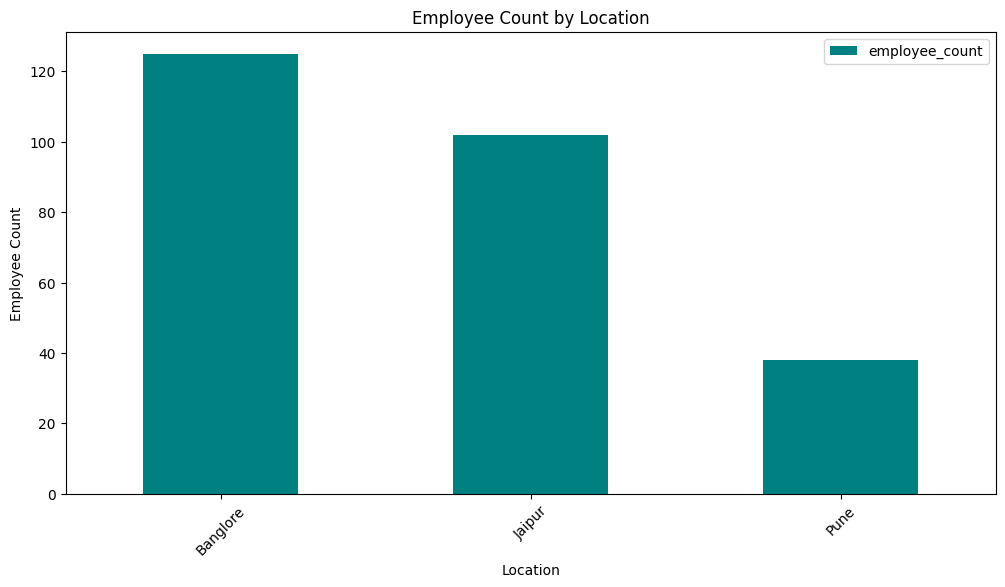

In [26]:
import matplotlib.pyplot as plt

employee_count_df.plot(kind='bar', x='location', y='employee_count', figsize=(12, 6), color='teal')
plt.title("Employee Count by Location")
plt.xlabel("Location")
plt.ylabel("Employee Count")
plt.xticks(rotation=45)
plt.show()


In [27]:
import pandas as pd
df = pd.read_excel('/content/Employee data (2).xlsx')
df.head()


,Name,Role,Location,Years of Experience,Active?,Current Comp (INR),Last Working Day
0,Aditi Khanna,Analyst,Jaipur,1,Y,653874.0,No
1,Pooja Kaur,Senior Analyst,Banglore,2,Y,798703.0,No
2,Kajal Mehta,Analyst,Banglore,1,Y,663851.0,No
3,Amaya Joshi,Analyst,Jaipur,0,Y,570000.0,No
4,Bilal Kulkarni,Associate,Jaipur,3,Y,976125.0,No


In [28]:
# Unique roles, locations, statuses
roles = df['Role'].dropna().unique()
locations = df['Location'].dropna().unique()
statuses = df['Active?'].dropna().unique()

print("Roles:", roles)
print("Locations:", locations)
print("Statuses:", statuses)


Roles: ['Analyst' 'Senior Analyst' 'Associate' 'Senior Associate'
 'Senir Associate' 'Manager']
Locations: ['Jaipur' 'Banglore' 'Pune']
Statuses: ['Y' 'N']


In [32]:
import sqlite3
conn = sqlite3.connect('employee_forecasting.db')
cursor = conn.cursor()

# Create Roles table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Roles (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    role TEXT UNIQUE NOT NULL
)
''')

# Create Locations table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Locations (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    location TEXT UNIQUE NOT NULL
)
''')

# Create Status table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Status (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    status TEXT UNIQUE NOT NULL
)
''')

# Create Employees table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Employees (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    role_id INTEGER,
    location_id INTEGER,
    years_of_experience INTEGER,
    active_id INTEGER,
    current_comp_inr REAL,
    last_working_day TEXT,
    FOREIGN KEY (role_id) REFERENCES Roles(id),
    FOREIGN KEY (location_id) REFERENCES Locations(id),
    FOREIGN KEY (active_id) REFERENCES Status(id)
)
''')

conn.commit()
print("✅ All normalized tables created successfully.")



✅ All normalized tables created successfully.


In [33]:
# Insert Roles
for role in roles:
    cursor.execute("INSERT OR IGNORE INTO Roles (role) VALUES (?)", (role,))

# Insert Locations
for location in locations:
    cursor.execute("INSERT OR IGNORE INTO Locations (location) VALUES (?)", (location,))

# Insert Statuses
for status in statuses:
    cursor.execute("INSERT OR IGNORE INTO Status (status) VALUES (?)", (status,))

conn.commit()
print("✅ Data inserted into Roles, Locations, and Status tables.")



✅ Data inserted into Roles, Locations, and Status tables.


In [34]:
from google.colab import files
files.download('/content/Employee data (2).xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
pip install streamlit pandas matplotlib openpyxl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.0 MB/s eta 0:00:00


In [37]:
!pip install ipywidgets



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00


In [39]:
import sqlite3

conn = sqlite3.connect("employee_forecasting.db")
cursor = conn.cursor()

cursor.execute('''
CREATE VIEW IF NOT EXISTS EmployeeDetails AS
SELECT
    e.name,
    r.role,
    l.location,
    e.years_of_experience,
    s.status,
    e.current_comp_inr,
    e.last_working_day
FROM Employees e
JOIN Roles r ON e.role_id = r.id
JOIN Locations l ON e.location_id = l.id
JOIN Status s ON e.active_id = s.id;
''')

conn.commit()
print("✅ View 'EmployeeDetails' created successfully.")


✅ View 'EmployeeDetails' created successfully.


In [41]:
# ✅ Display average compensation for selected location
avg_query = """
SELECT AVG(current_comp_inr) AS avg_compensation
FROM EmployeeDetails
WHERE location = ?""" + (" AND status = 'Y'" if not include_inactive else "")
avg_comp = pd.read_sql_query(avg_query, conn, params=[selected_location])

# Add this check
if avg_comp['avg_compensation'][0] is not None:
    print(f"📊 Average Compensation in {selected_location}: ₹{avg_comp['avg_compensation'][0]:,.2f}")
else:
    print(f"⚠️ No matching employee data found for location: {selected_location}")


⚠️ No matching employee data found for location: Jaipur


In [42]:
# View all unique roles, locations, and statuses
print("🔍 Roles:\n", pd.read_sql_query("SELECT DISTINCT role FROM EmployeeDetails", conn))
print("\n📍 Locations:\n", pd.read_sql_query("SELECT DISTINCT location FROM EmployeeDetails", conn))
print("\n✅ Status:\n", pd.read_sql_query("SELECT DISTINCT status FROM EmployeeDetails", conn))


🔍 Roles:
 Empty DataFrame
Columns: [role]
Index: []

📍 Locations:
 Empty DataFrame
Columns: [location]
Index: []

✅ Status:
 Empty DataFrame
Columns: [status]
Index: []


In [43]:
# Show all employee data for testing
test_df = pd.read_sql_query("SELECT name, role, locat🔍 Roles:
 Empty DataFrame
Columns: [role]
Index: []

📍 Locations:
 Empty DataFrame
Columns: [location]
Index: []

✅ Status:
 Empty DataFrame
Columns: [status]
Index: []ion, current_comp_inr, status FROM EmployeeDetails", conn)
print(test_df.head(10))


Empty DataFrame
Columns: [name, role, location, current_comp_inr, status]
Index: []


In [44]:
selected_role = "Analyst"
selected_location = "Banglore"  # Use exact match from your data
include_inactive = False


In [48]:
import pandas as pd

# Load the cleaned Excel file you uploaded earlier
df = pd.read_excel('/content/Employee data (2) (1).xlsx')

# Rename columns to match schema
df.rename(columns={
    'Employee Name': 'name',
    'Role': 'role',
    'Location': 'location',
    'Years of Experience': 'years_of_experience',
    'Current Compensation (INR)': 'current_comp_inr',
    'Status (Active/Inactive)': 'status',
    'Last Working Day': 'last_working_day'
}, inplace=True)


In [51]:
import pandas as pd

df = pd.read_excel('/content/Employee data (2) (1).xlsx')
print(df.columns.tolist())


['Name', 'Role', 'Location', 'Years of Experience', 'Active?', 'Current Comp (INR)', 'Last Working Day']


🎯 Filtered Employee Data:
Empty DataFrame
Columns: [name, role, location, current_comp_inr, status]
Index: []

⚠️ No data available to calculate average compensation in Bangalore.


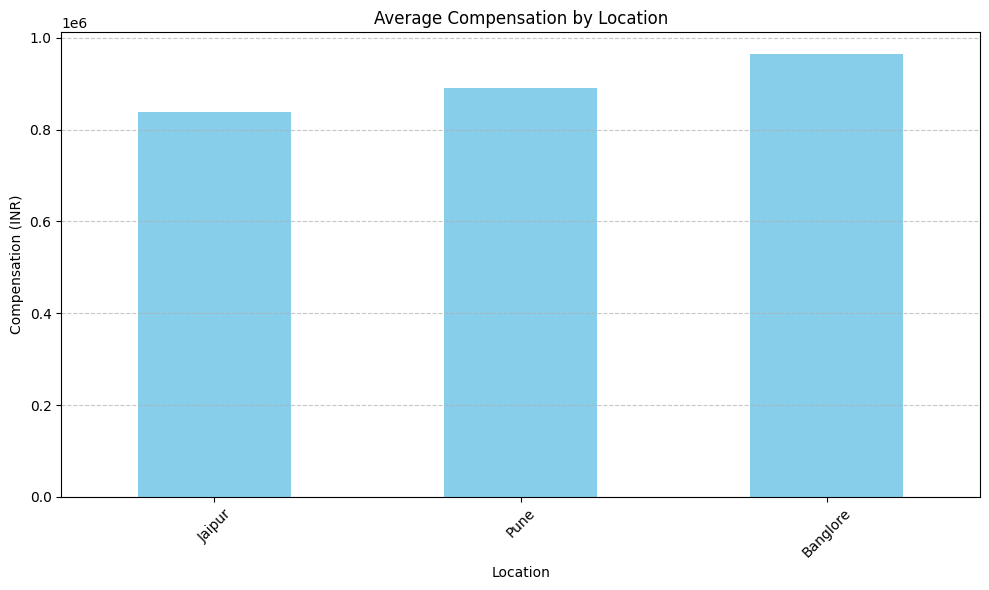

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your cleaned Excel file
df = pd.read_excel("/content/Employee data (2) (1).xlsx")

# Rename columns for easier use
df.rename(columns={
    'Name': 'name',
    'Role': 'role',
    'Location': 'location',
    'Years of Experience': 'years_of_experience',
    'Active?': 'status',
    'Current Comp (INR)': 'current_comp_inr',
    'Last Working Day': 'last_working_day'
}, inplace=True)

# Clean status column
df['status'] = df['status'].str.upper().str.strip()

# Unique filters
roles = df['role'].dropna().unique()
locations = df['location'].dropna().unique()

# Simulate user inputs
selected_role = 'Software Engineer'   # Change as needed
selected_location = 'Bangalore'       # Change as needed
include_inactive = False              # Toggle True to include inactive

# Apply filters
filtered_df = df.copy()
if selected_role:
    filtered_df = filtered_df[filtered_df['role'] == selected_role]
if selected_location:
    filtered_df = filtered_df[filtered_df['location'] == selected_location]
if not include_inactive:
    filtered_df = filtered_df[filtered_df['status'] == 'Y']

# Display filtered employees
print("🎯 Filtered Employee Data:")
display_cols = ['name', 'role', 'location', 'current_comp_inr', 'status']
print(filtered_df[display_cols])

# 🔢 Average compensation for selected location
loc_filter = df[df['location'] == selected_location]
if not include_inactive:
    loc_filter = loc_filter[loc_filter['status'] == 'Y']
avg_comp = loc_filter['current_comp_inr'].mean()

if pd.notna(avg_comp):
    print(f"\n📊 Average Compensation in {selected_location}: ₹{avg_comp:,.2f}")
else:
    print(f"\n⚠️ No data available to calculate average compensation in {selected_location}.")

# 📊 Bar chart: Avg compensation across all locations
if not include_inactive:
    df_plot = df[df['status'] == 'Y']
else:
    df_plot = df.copy()

bar_data = df_plot.groupby('location')['current_comp_inr'].mean().sort_values()

# Plot
plt.figure(figsize=(10, 6))
bar_data.plot(kind='bar', color='skyblue')
plt.title("Average Compensation by Location")
plt.ylabel("Compensation (INR)")
plt.xlabel("Location")
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [54]:
# Fix misspellings in role column
df['role'] = df['role'].replace({
    'Senir Associate': 'Senior Associate'
})


In [57]:
import pandas as pd

# ✅ Step 1: Load cleaned data
df = pd.read_excel('/content/Employee data (2) (1).xlsx')

# ✅ Step 2: Rename columns for consistency
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df.rename(columns={
    'name': 'name',
    'role': 'role',
    'location': 'location',
    'years_of_experience': 'experience',
    'active?': 'status',
    'current_comp_(inr)': 'current_comp_inr'
}, inplace=True)

# ✅ Step 3: Fix spelling issues in 'role'
df['role'] = df['role'].replace({
    'Senir Associate': 'Senior Associate'
})

# ✅ Step 4: Define experience ranges
bins = [0, 1, 2, 5, 10, 20, 100]
labels = ['0–1 yrs', '1–2 yrs', '2–5 yrs', '5–10 yrs', '10–20 yrs', '20+ yrs']
df['experience_range'] = pd.cut(df['experience'], bins=bins, labels=labels, right=False)

# ✅ Step 5: Ask user how to group — by Role or Location
group_by = 'role'  # change to 'location' for location-based breakdown

# ✅ Step 6: Group and count
grouped = df.groupby(['experience_range', group_by])['name'].count().reset_index()
grouped.rename(columns={'name': 'employee_count'}, inplace=True)

# ✅ Step 7: Display results
print("📌 Employee count by experience range:")
print(grouped)


📌 Employee count by experience range:
   experience_range              role  employee_count
0           0–1 yrs           Analyst              78
1           0–1 yrs         Associate               0
2           0–1 yrs           Manager               0
3           0–1 yrs    Senior Analyst               0
4           0–1 yrs  Senior Associate               7
5           1–2 yrs           Analyst              73
6           1–2 yrs         Associate               0
7           1–2 yrs           Manager               0
8           1–2 yrs    Senior Analyst               7
9           1–2 yrs  Senior Associate               1
10          2–5 yrs           Analyst               0
11          2–5 yrs         Associate              46
12          2–5 yrs           Manager               0
13          2–5 yrs    Senior Analyst              68
14          2–5 yrs  Senior Associate               4
15         5–10 yrs           Analyst               0
16         5–10 yrs         Associate       

<ipython-input-57-9d33adee5ab7>:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['experience_range', group_by])['name'].count().reset_index()


📌 Sample Data with Updated Compensation:
               name            role  location  current_comp_inr  \
0      Aditi Khanna         Analyst    Jaipur          653874.0   
1        Pooja Kaur  Senior Analyst  Banglore          798703.0   
2       Kajal Mehta         Analyst  Banglore          663851.0   
3       Amaya Joshi         Analyst    Jaipur          570000.0   
4    Bilal Kulkarni       Associate    Jaipur          976125.0   
5      Girish Reddy         Analyst      Pune          670531.0   
6      Esha Dhillon         Analyst      Pune          652076.0   
7        Kashi Nair         Analyst  Banglore          655787.0   
8  Himanshu Dhillon  Senior Analyst      Pune          895396.0   
9      Hetal Bhatia  Senior Analyst      Pune          820895.0   

   applied_increment_%  updated_comp  
0                   10      719261.4  
1                   10      878573.3  
2                   10      730236.1  
3                   10      627000.0  
4                   10    

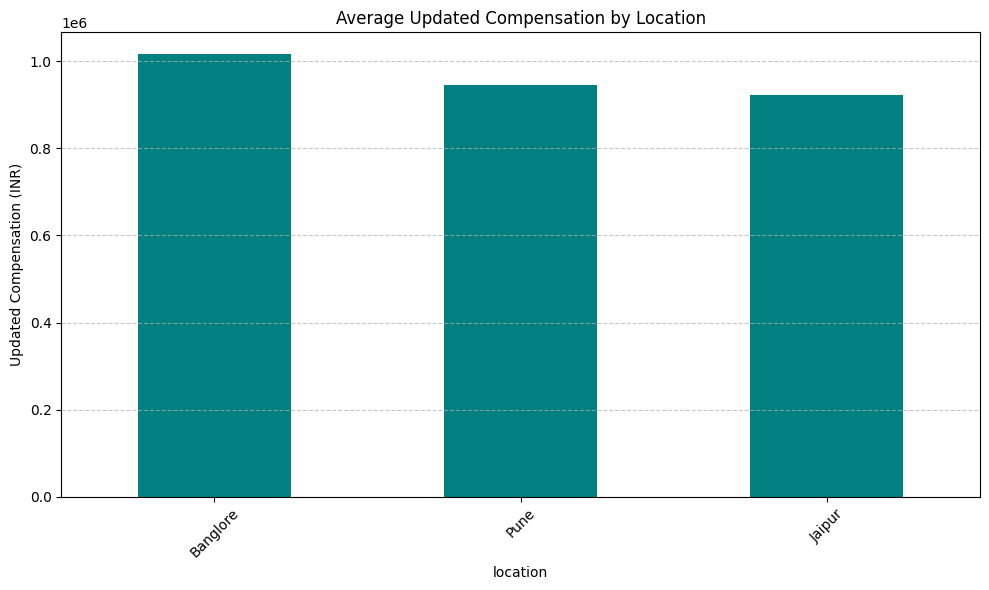

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# 🧼 Step 1: Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# ✅ Step 2: Normalize column values
df['role'] = df['role'].str.strip().str.title()
df['location'] = df['location'].str.strip().str.title()
df['status'] = df['status'].str.strip().str.upper()

# 🎯 Step 3: Define global and custom increments
global_increment = 10  # %

custom_increments = {
    'Bangalore': 12,
    'Gurgaon': 15,
    'Jaipur': 10
}

# 🧮 Step 4: Apply increment logic
df['applied_increment_%'] = df['location'].apply(lambda x: custom_increments.get(x, global_increment))
df['updated_comp'] = df['current_comp_inr'] * (1 + df['applied_increment_%'] / 100)
df['updated_comp'] = df['updated_comp'].round(2)

# 🧾 Step 5: Display updated compensation table
df_incremented = df[['name', 'role', 'location', 'current_comp_inr', 'applied_increment_%', 'updated_comp']]
print("📌 Sample Data with Updated Compensation:")
print(df_incremented.head(10))

# 📊 Step 6: Visualization – Avg updated comp by location
avg_updated = df.groupby('location')['updated_comp'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
avg_updated.plot(kind='bar', color='teal')
plt.title('Average Updated Compensation by Location')
plt.ylabel('Updated Compensation (INR)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [62]:
import pandas as pd

# ✅ Step 1: Clean and normalize data
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

df['role'] = df['role'].str.strip().str.title()
df['location'] = df['location'].str.strip().str.title()
df['status'] = df['status'].str.strip().str.upper()

# ✅ Step 2: Optional – Apply increment if not already done
if 'applied_increment_%' not in df.columns:
    global_increment = 10  # Default
    custom_increments = {
        'Bangalore': 12,
        'Gurgaon': 15,
        'Jaipur': 10
    }

    df['applied_increment_%'] = df['location'].apply(lambda x: custom_increments.get(x, global_increment))
    df['updated_comp'] = df['current_comp_inr'] * (1 + df['applied_increment_%'] / 100)
    df['updated_comp'] = df['updated_comp'].round(2)

# ✅ Step 3: Create filtered export table
export_df = df[[
    'name',
    'role',
    'location',
    'experience',
    'updated_comp',  # this includes applied increment
    'status'
]].rename(columns={
    'updated_comp': 'compensation'
})

# ✅ Step 4: Export to CSV
csv_path = '/content/filtered_employees.csv'
export_df.to_csv(csv_path, index=False)
print(f"✅ Filtered data exported to: {csv_path}")


✅ Filtered data exported to: /content/filtered_employees.csv


In [65]:
# streamlit_app.py

import streamlit as st
import pandas as pd

# Load your CSV
df = pd.read_csv("filtered_employees.csv")

# Streamlit UI Elements
st.title("Employee Compensation Forecasting")

# Filters
role = st.selectbox("Select Role", df["role"].unique())
location = st.selectbox("Select Location", df["location"].unique())
include_inactive = st.checkbox("Include Inactive Employees")

# Filter data
filtered_df = df[
    (df["role"] == role) &
    (df["location"] == location)
]
if not include_inactive:
    filtered_df = filtered_df[filtered_df["status"] == "Y"]

st.dataframe(filtered_df[["name", "role", "location", "compensation", "status"]])


2025-05-18 11:02:52.992 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-18 11:02:52.994 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-18 11:02:52.996 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-18 11:02:52.997 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-18 11:02:53.001 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-18 11:02:53.002 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-18 11:02:53.004 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-18 11:02:53.005 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()